In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# !pip install geopandas
# !pip install matplotlib_scalebar
# !pip install mapclassify
# !pip install ipython-autotime
# !pip install matplotlib-scalebar
# !pip install xlrd
# !pip install shapely
# %load_ext autotime

import pandas as pd
import os
import sys
import numpy as np
import ast
import geopandas as gpd
import re
import math
import copy

from urllib.request import urlopen
from zipfile import ZipFile

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.dates import MonthLocator, DateFormatter

import requests
from io import StringIO
from shapely.geometry import Point

from matplotlib_scalebar.scalebar import ScaleBar


import matplotlib as mpl
import shapely

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')

# Helper function

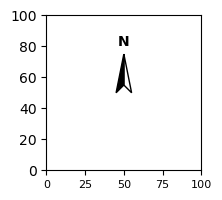

In [23]:
# Function to draw north arrow
import shapely.plotting
from shapely.geometry import Polygon

def plot_north_arrow(ax, xT=0, yT=0, scale=1, fontsize=30, linewidth=2):
    def t_s(t,xT,yT,s):
        x,y = t
        return (xT+(x*s),yT+(y*s))
    # a = [(0, 5), (0, 1), (2, 0)]
    # b = [(0, 5), (0, 1), (-2, 0)]
    # t_pos = (0.0,6)
    
    a = [(0, 5/20), (0, 1/20), (1/20, 0)] # top, midlle, right point
    b = [(0, 5/20), (0, 1/20), (-1/20, 0)]
    t_pos = (0.0, 6/20)
    
    t_pos_x,t_pos_y = t_s(t_pos,xT,yT,scale)
    t_pos_y = t_pos_y + 0.03
    polygon1 = Polygon( [t_s(t,xT,yT,scale) for t in a] )
    polygon2 = Polygon( [t_s(t,xT,yT,scale) for t in b] )
    shapely.plotting.plot_polygon(polygon1, add_points=False, ax=ax, color=None, facecolor='None', edgecolor='k', linewidth=linewidth*scale, transform=ax.transAxes,)
    shapely.plotting.plot_polygon(polygon2, add_points=False, ax=ax, color=None, facecolor='k', edgecolor='k', linewidth=None, transform=ax.transAxes,)
    ax.text(x=t_pos_x,y=t_pos_y,s='N', fontsize=fontsize,
             transform=ax.transAxes,
            ha='center',
            va='center',weight='bold')
    
fig, ax = plt.subplots(figsize=(2,3))
#...
#... your mapping code...
#...
plot_north_arrow(ax, xT=0.5, yT=0.5, scale=1, fontsize=10, linewidth=1)

# 
# -- Just for the sample plots.
_ = ax.set_xlim(0,100)
_ = ax.set_ylim(0,100)

 
# fig, ax = plt.subplots(figsize=(2,3))
ax.set_aspect('equal', adjustable='box')
 

Reading state and county boudaries...
Reading tract boudaries...
Reading blockgroup boudaries...


<Axes: >

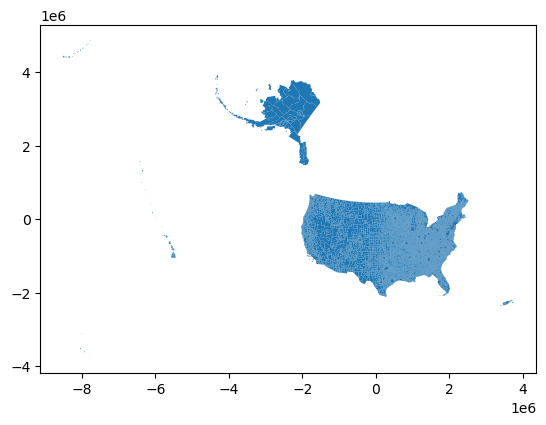

In [14]:
def Load_boundary(shapefile_url):
    # unzip files
    # zipresp = urlopen(shapefile_url)
    # tempzip = open("tempfile.zip", "wb")
    # tempzip.write(zipresp.read())
    # tempzip.close()
    # zf = ZipFile("tempfile.zip")
    # zf.extractall(path = 'us_counties.shp')
    # zf.close()

    gdf = gpd.read_file(shapefile_url).to_crs(2163)  # US National Atlas Equal Area   # .query("STATEFP == '45' ")
    print(f"Feature count: {len(gdf)}")
    # gdf['GEOID'] = gdf['GEOID'].str.zfill(5)

    return gdf
    
# shapefile_url = r'https://github.com/gladcolor/spatial_data/raw/master/cb_2019_us_state_20m.zip'
# shapefile_url = r'https://github.com/gladcolor/spatial_data/raw/master/cb_2019_us_county_20m.zip'

def load_US_boundaries(tract=False, blockgroup=False):
    
    print("Reading state and county boudaries...")
    state_url = r'https://github.com/gladcolor/spatial_data/raw/master/cb_2019_us_state_20m.zip'
    state_gdf = gpd.read_file(state_url).to_crs(2163)  # US National Atlas Equal Area   # .query("STATEFP == '45' ")

    county_url = r'https://github.com/gladcolor/spatial_data/raw/master/cb_2019_us_county_20m.zip'
    county_gdf = gpd.read_file(county_url).to_crs(2163)  # US National Atlas Equal Area   # .query("STATEFP == '45' ")

    tract_gdf = None
    if tract:
        print("Reading tract boudaries...")
        # tract_url = r'/content/drive/MyDrive/Research/Homophily/tract_shape.zip'
        # tract_url = r'T:\My Drive\Research\Homophily\tract_shape.zip'
        tract_url = r'D:\OneDrive_USC\OneDrive - University of South Carolina\Research\homophily\ArcGISPro\Homophily\tract_shape.zip'
        tract_gdf = gpd.read_file(tract_url).to_crs(2163)  # US National Atlas Equal Area   # .query("STATEFP == '45' ")
        tract_gdf['GEOID'] = tract_gdf['Tract']

    cbg_gdf = None
    if blockgroup:
        print("Reading blockgroup boudaries...")
        # cbg_url = r'T:\Shared drives\T5\safegraph_bias\blockgoups\blockgoups2019.shp'
        cbg_url = r'D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_data\Safegraph_bias\blockgoups\blockgoups2019.shp'
        # cbg_url = r'/content/drive/Shareddrives/T5/safegraph_bias/blockgoups/blockgoups2019.shp'  # Google drive
        cbg_gdf = gpd.read_file(cbg_url).to_crs(2163)  # US National Atlas Equal Area   # .query("STATEFP == '45' ")
        # cbg_gdf['GEOID'] = cbg_gdf['CensusBloc']

    us_boundary = {'state': state_gdf,
                   'county': county_gdf,
                   'tract': tract_gdf,
                   'cbg': cbg_gdf}

    return us_boundary

# gdf = Load_boundary(shapefile_url=shapefile_url)
# gdf.plot(figsize=(10, 10), column='ALAND')

mpl.style.use('default')
# us_boundary = load_US_boundaries(tract=True, blockgroup=True) # , county_gdf, tract_gdf
us_boundary = load_US_boundaries(tract=True, blockgroup=True) # , county_gdf, tract_gdf

# us_boundary['state'].plot()
us_boundary['state'].plot()

In [15]:
save_dir = r'F:\Research\safegraph_bias\figures_20230917'
data_dir = r'F:\Research\Safegraph_bias\20230916'
os.makedirs(save_dir, exist_ok=True)

columns = ['Female', 'Male',
        '15–17', '18–24', '25–34', '35–44', '45–54', '55–64', '>65',
       'White', 'Black', 'Hispanic', 'Asian', 'NoSchool', 'HighSchool',
       'NoCollege', 'Bachelor', 'Graduate', '<20K', '20K–30K', '30K–50K',
       '50K–100K', '>100K']

In [16]:
# save_dir = r'/content/drive/Shareddrives/T5/safegraph_bias/figures'
# data_dir = r'/content/drive/Shareddrives/T5/safegraph_bias'

# save_dir = r'T:\Shared drives\T5\safegraph_bias\figures'
# data_dir = r'T:\Shared drives\T5\safegraph_bias'





# monthly_files = glob.glob(os.path.join(data_dir, r'sampling_rates_*_monthly.csv'))

urban_rural_county_xls = os.path.join(data_dir, 'ruralurbancodes2013.xls')
urban_rural_county_df = pd.read_excel(urban_rural_county_xls, dtype={'FIPS':str})

urban_rural_tract_csv = os.path.join(data_dir, 'FoodAccessResearchAtlasData2019.csv')
urban_rural_tract_df = pd.read_csv(urban_rural_tract_csv, dtype={'fips':str}, encoding='UTF-8')


urban_rural_cbg_csv = os.path.join(data_dir, 'CBG_urbanization_2type_2019.csv')
urban_rural_cbg_df = pd.read_csv(urban_rural_cbg_csv, dtype={'CBG_FIPS':str})

years = [2022, 2019, 2020, 2021, 2018]
levels = ['state', 'county', 'tract', 'cbg']

data_dict = {}

for year in years:

    csv_file = os.path.join(data_dir, f'sampling_rates_{year}_monthly_yearly.csv')
    df = pd.read_csv(csv_file, dtype={'fips':str})
  
    # df = pd.concat(df_list).fillna("0")
    # df['county_FIPS'] = df['county_fips'].astype(int).astype(str).str[:5]
    # df['bias_value'] = df['safegraph_ratio_mean_to_census'].astype(float) - 1
    data_dict[year] = df

data_dict[2019].sample(5)

year          fips  start_date  end_date  period_count  CBG_count  device_count_mean  population  sampling_rate_mean  sampling_rate_max  sampling_rate_min  fips_len fips_level
272118  2019  510594916021      201901    201912            12        1.0         200.166667      3109.0            0.064383           0.070441           0.055645        12        cbg
5487    2019   04003000202      201901    201912            12        4.0         185.416667      3686.0            0.050303           0.061042           0.041780        11      tract
106468  2019   20209041800      201901    201912            12        1.0         146.083333      1025.0            0.142520           0.301463           0.106341        11      tract
262907  2019  484230020042      201901    201912            12        1.0          77.583333      1032.0            0.075178           0.093023           0.061047        12        cbg
188908  2019  361019621001      201901    201912            12        1.0          94.250000      1800.0            0.052361           0.064444           0.039444        12        cbg

In [17]:
merged_year_level_gdf_dict = {}

for year in years:
    submap_gdf_dict = {}
    for level, gdf in us_boundary.items():
        level_df = data_dict[year].query(f"fips_level == '{level}' ")
        merged_gdf = gdf.merge(level_df, left_on='GEOID', right_on='fips')
        submap_gdf_dict[level] = merged_gdf

    merged_year_level_gdf_dict[year] = submap_gdf_dict

len(merged_year_level_gdf_dict)

5

0 coolwarm / 1
Year: 2019
Level: state
Level: county
Level: tract
Level: cbg
Year: 2022
Level: state
Level: county
Level: tract
Level: cbg
Year: 2020
Level: state
Level: county
Level: tract
Level: cbg
Year: 2021
Level: state
Level: county
Level: tract
Level: cbg
Year: 2018
Level: state
Level: county
Level: tract
Level: cbg
Done


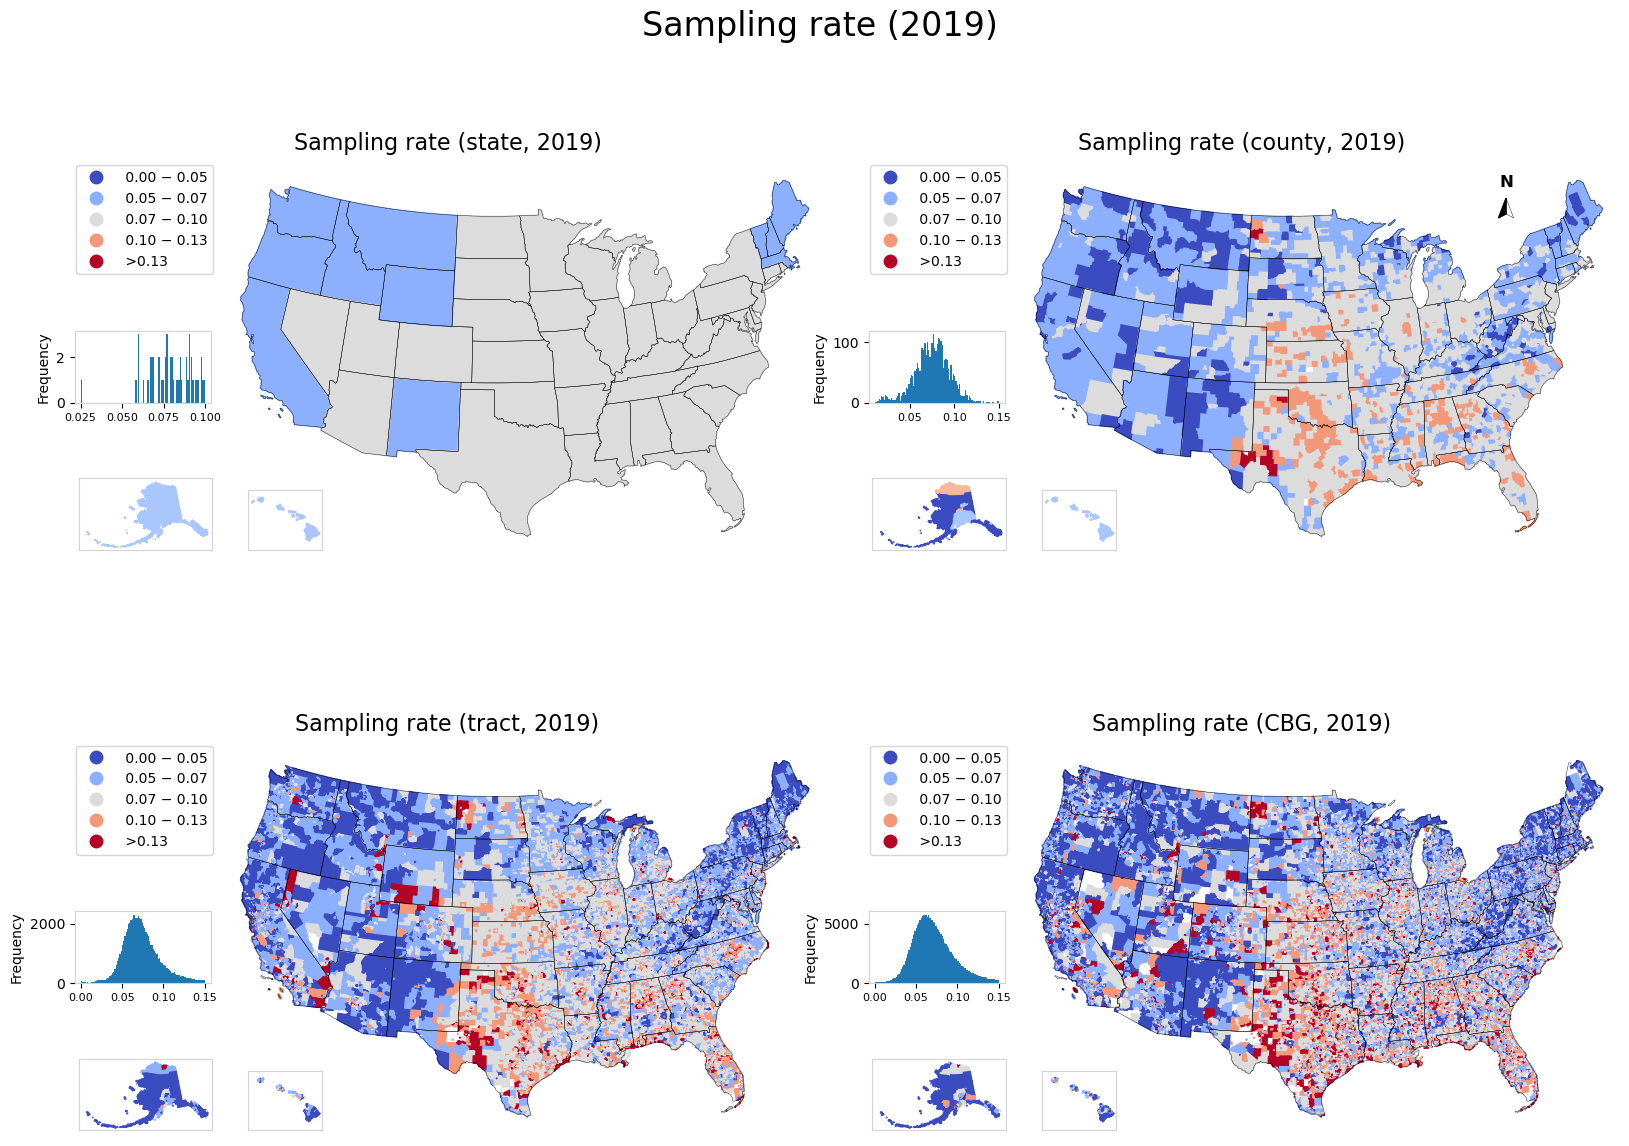

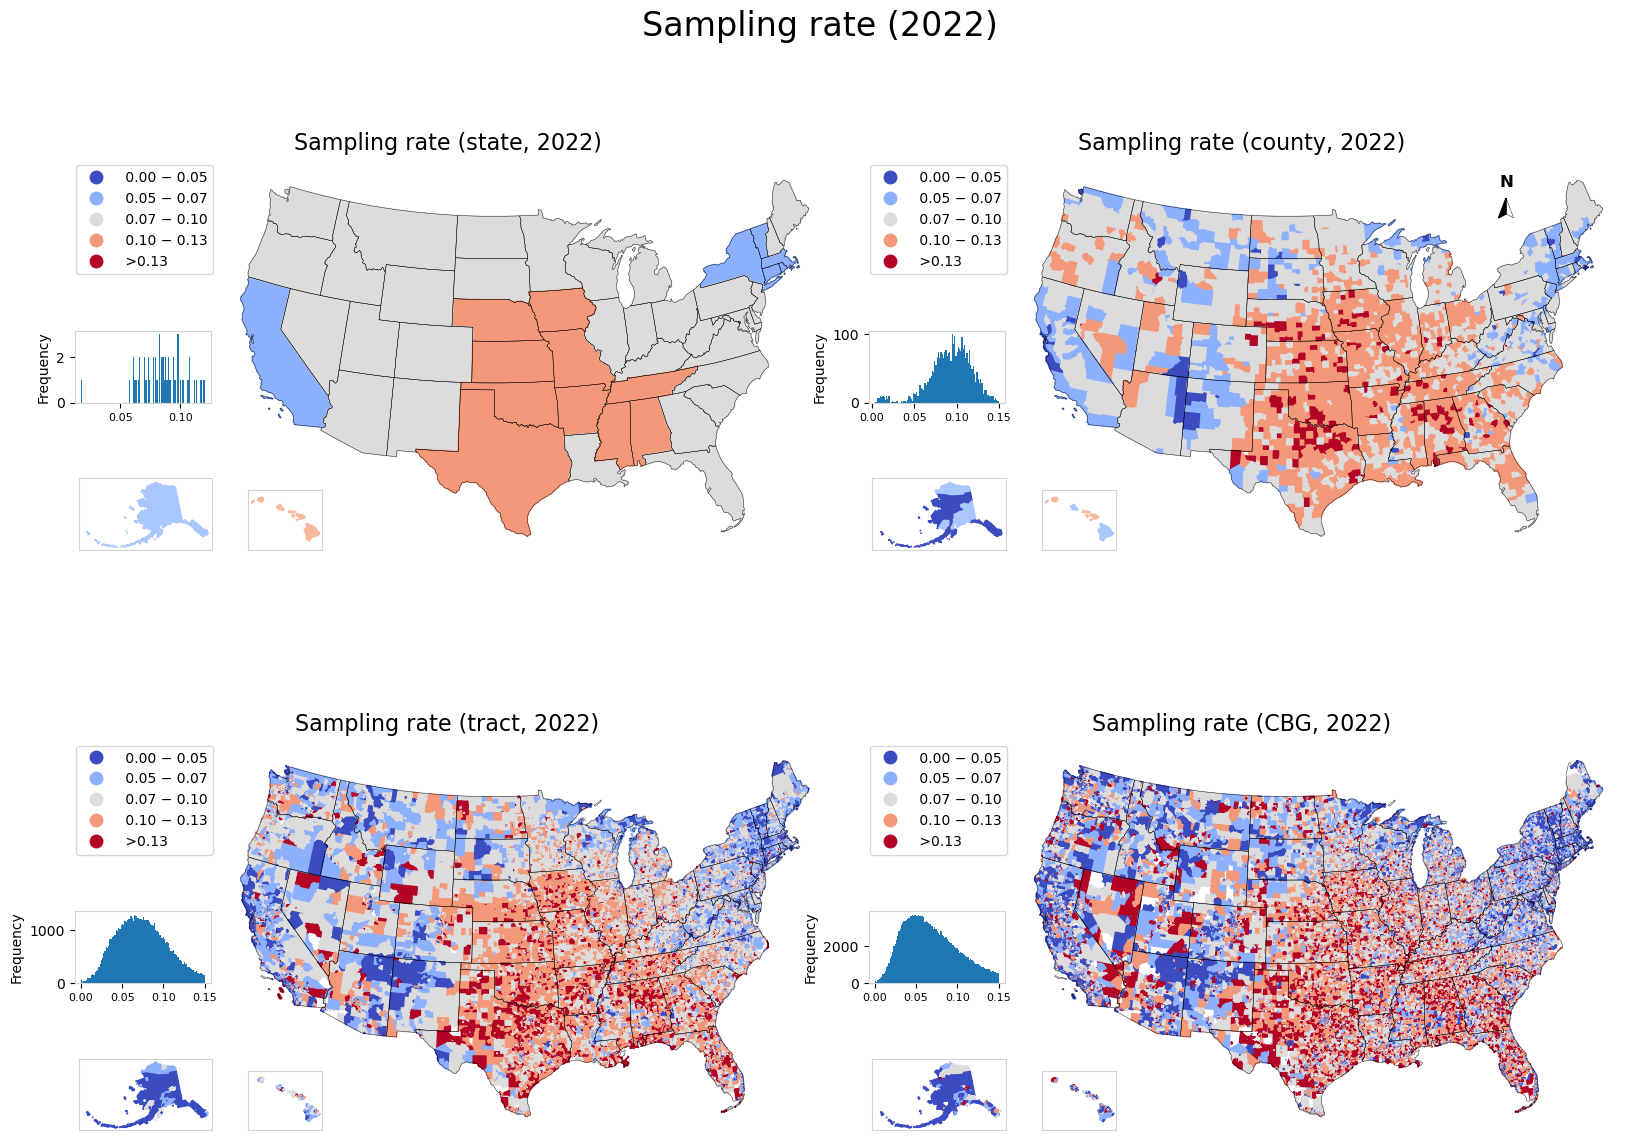

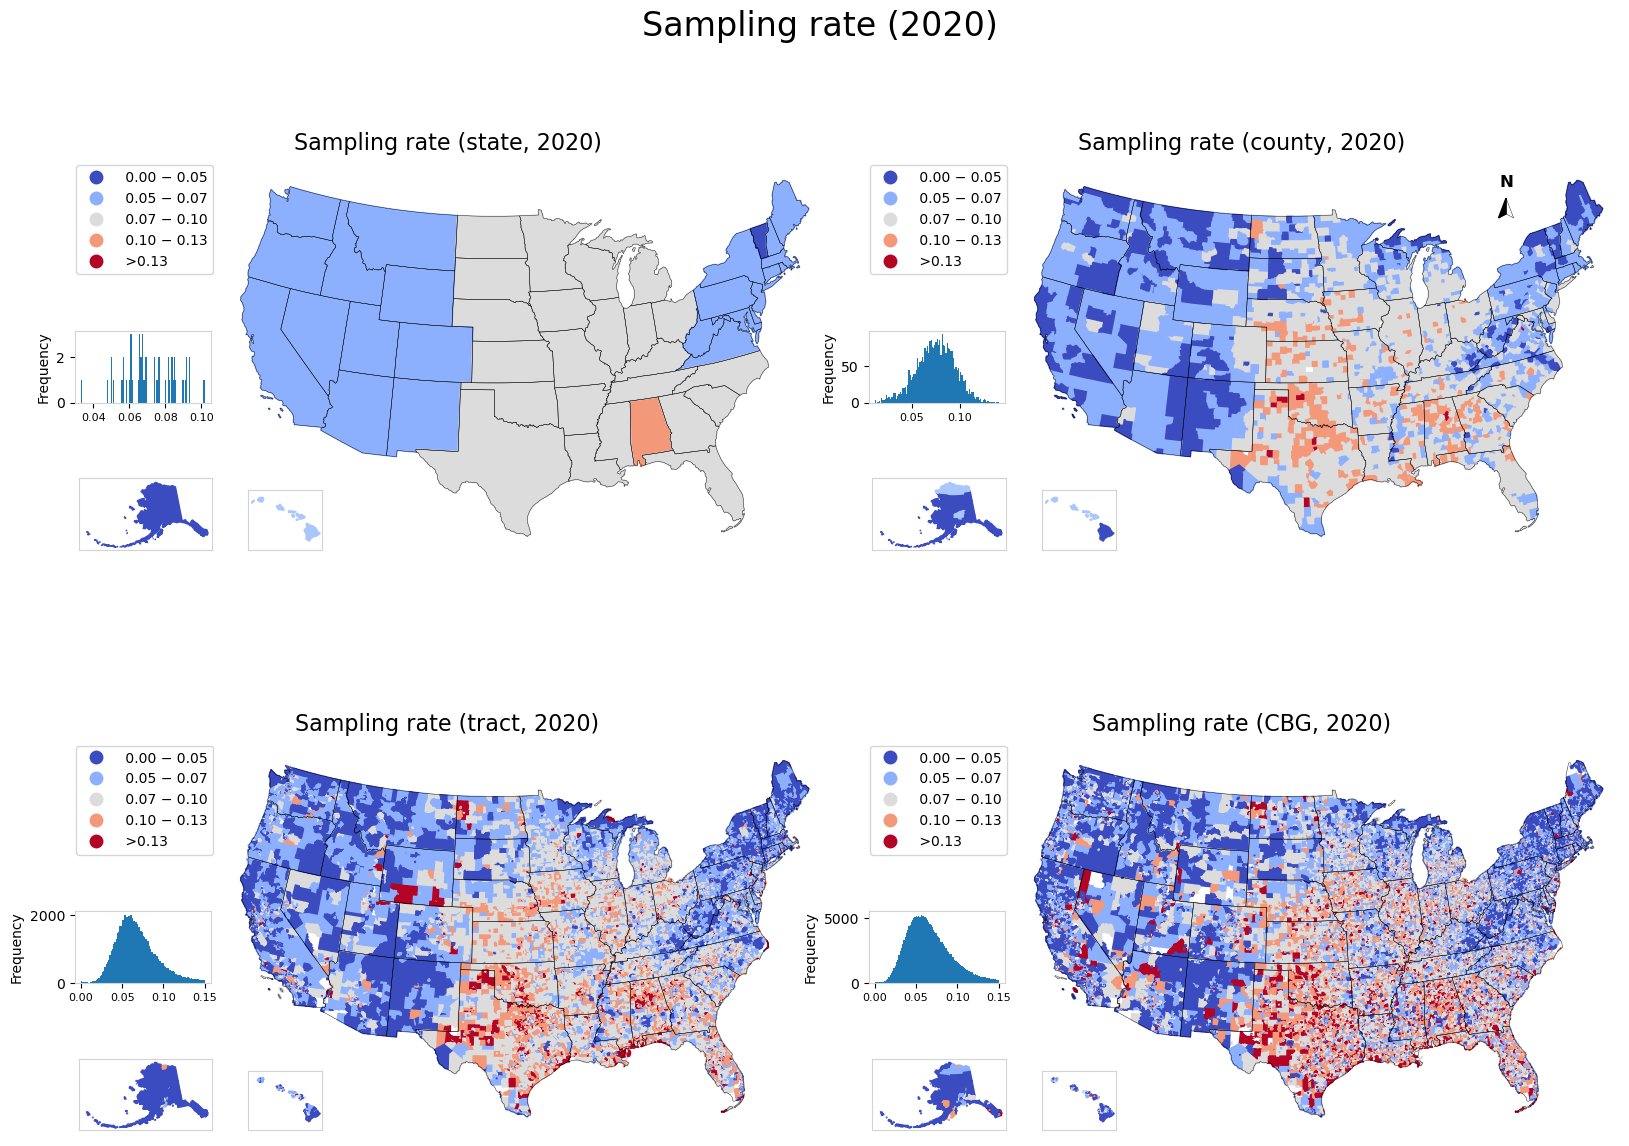

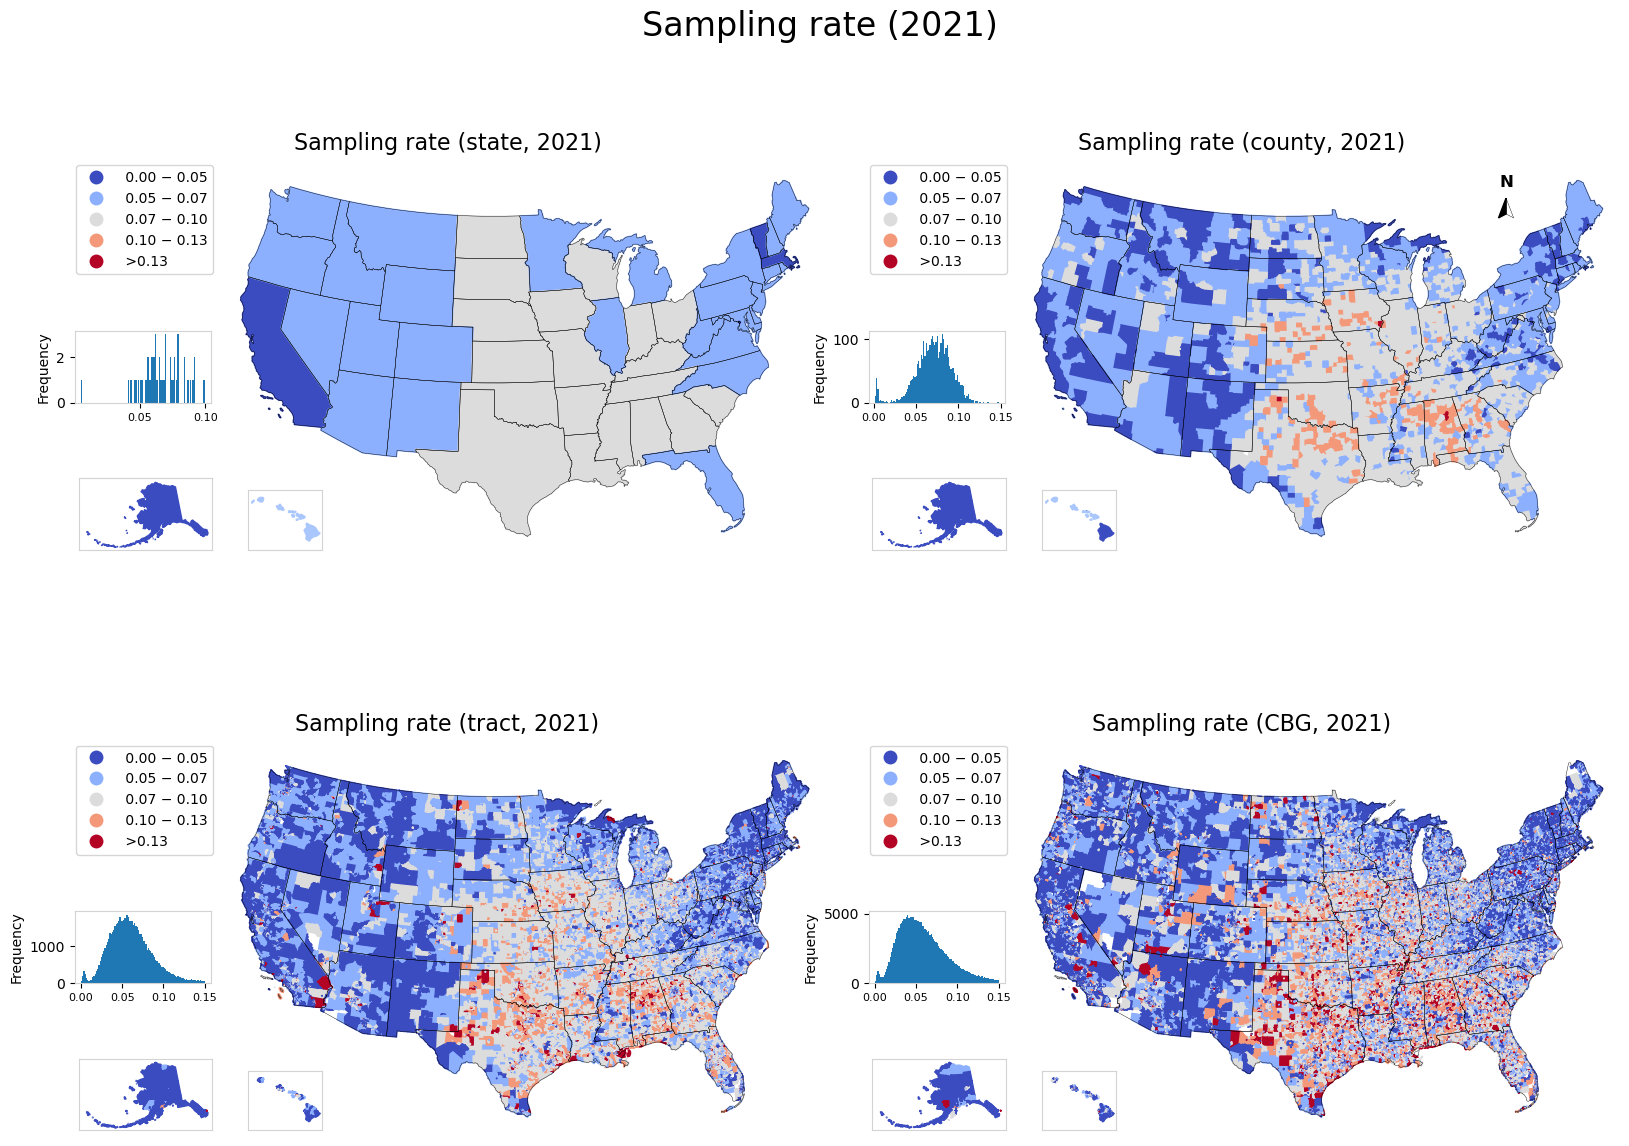

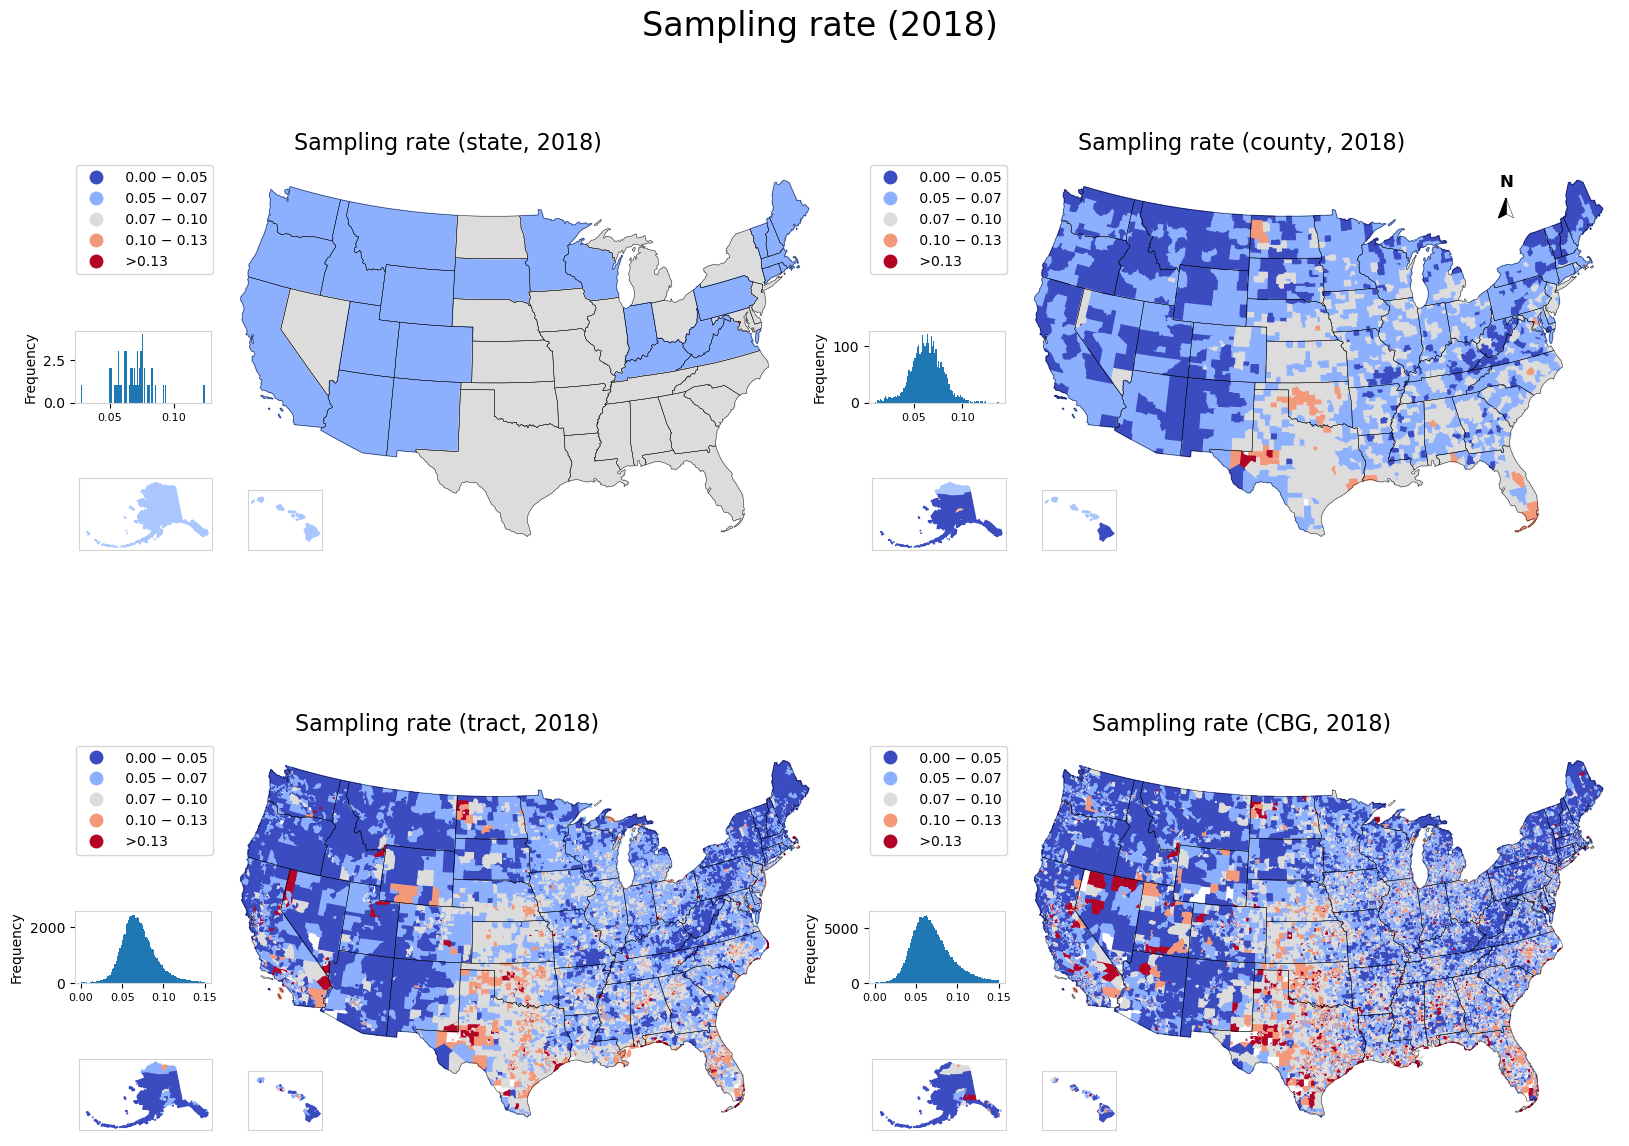

In [25]:
column = 'sampling_rate_mean'
from shapely.geometry import Polygon

def draw_us_ak_hi_map(fig, ax, us_gdf, column, year=year, value_max=0.2, value_min =0, cmap='coolwarm'): 
 
    bins = [0.05, 0.07, 0.1, 0.13]  

    ax.set_xlim(-2267347 * 1.5, 2649890)    # 
    ax.set_ylim(-2270798, 908769 * 1.0)    # 
    # us_gdf.plot(ax=ax, column=column, vmax=value_max, vmin=value_min, cmap=cmap, legend=True, scheme="EqualInterval", )
    us_gdf.plot(ax=ax, cmap=cmap, column=column,  scheme="User_Defined", 
                                                classification_kwds=dict(bins=bins),
                                                    # vmax=value_max,  # if set to 0.2, will have two colors only, bad.
                                                    vmin=0.0,
                                                     legend_kwds={'loc': 'upper left'},
                                                    legend=True,edgecolor="face")    
    # draw state boundary
    if DRAW_BOUNDARY:
        us_boundary['state'].plot(ax=ax, facecolor="none",   
                                  edgecolor='black', lw=0.3)
    
    clean_legend(ax, bins)


    [left, bottom, height, width] = ax.get_position().bounds
    # ax_ak = fig.add_axes((left + width * 0.01, bottom + height * 0.01, height * 0.2, width * 0.2))
    
  
    subax = fig.add_axes((left + width * 0.01, bottom + height * 0.27, height * 0.18, width * 0.18))  # ,axisbg=axisbg
    subax.set_xlabel("Sampling rate")
    
    level = us_gdf.iloc[0]['fips_level']

     
    if level == 'state':
        # us_gdf.query(" sampling_rate_mean < 0.10 ")[column].plot.hist(bins=100, ax=subax)
        us_gdf = us_gdf.iloc[:-2]  # remove the fake polygons
    # else:
    us_gdf.query(" sampling_rate_mean < 0.15 ")[column].plot.hist(bins=100, ax=subax)

    for spine in subax.spines.values():
        spine.set_edgecolor('lightgrey')

    # print(ax.get_position())
 
    ak_crs = "EPSG:6393"  # NAD83(2011) / Alaska Albers
    [left, bottom, height, width] = ax.get_position().bounds
    ax_ak = fig.add_axes((left + width * 0.0, bottom + height * 0.01, height * 0.2, width * 0.18))  # left, bottom, height, width
    ax_ak.set_xlim(-2416147, 1601733)
    ax_ak.set_ylim(331159, 2490481)
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    for spine in ax_ak.spines.values():
        spine.set_edgecolor('lightgrey')
    ak_gdf = us_gdf[us_gdf['GEOID'].str.startswith('02')]
    # ak_gdf.to_crs(ak_crs).plot(ax=ax_ak, column=column, vmax=value_max, vmin=value_min, cmap=cmap)
    ak_gdf.to_crs(ak_crs).plot(ax=ax_ak, cmap=cmap, column=column,  scheme="User_Defined", 
                                                     classification_kwds=dict(bins=bins),
                                                    # vmax=value_max, 
                                                    vmin=0.0,
                                                    legend=False, edgecolor="face")
    # us_gdf.to_crs(ak_crs).plot(ax=ax_hi, column=column, vmax=value_max, vmin=value_min, cmap=cmap)  # 


    hi_crs = "ESRI:102007"  # NAD 1983 Albers Hawaii
    [left, bottom, height, width] = ax.get_position().bounds
    ax_hi = fig.add_axes((left + width * 0.30, bottom + height * 0.010, height * 0.15, width * 0.15))  # left, bottom, height, width
    ax_hi.set_xlim(-370902,  251047)
    ax_hi.set_ylim(583159, 1080360)
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    for spine in ax_hi.spines.values():
        spine.set_edgecolor('lightgrey')
    # us_gdf.to_crs(hi_crs).plot(ax=ax_hi, column=column, vmax=value_max, vmin=value_min, cmap=cmap)
    hi_gdf = us_gdf[us_gdf['GEOID'].str.startswith('15')]
    hi_gdf.to_crs(hi_crs).plot(ax=ax_hi, cmap=cmap, column=column,  scheme="User_Defined", 
                                                     classification_kwds=dict(bins=bins),
                                                    # vmax=value_max, 
                                                    vmin=0.0,
                                                    legend=False, edgecolor="face")

def clean_legend(axs, bins):
    leg = axs.get_legend()
    bins2 = [0] + bins
    for idx, text in enumerate(leg.get_texts()):

        # print("raw label:", text)
        
        if idx == (len(leg.get_texts()) - 1):
            # print("5:", 5)
            last_label = " >" + str(bins[-1])
            text.set_text(last_label)
            # print("Last label: ", last_label)
        else:
            # print(idx, text, len(leg.get_texts()))
            label = f" {bins2[idx]:.2f} − {bins2[idx + 1]:.2f}"
            text.set_text(label)
            # print("Label", label)

 
def draw_map_matrix(fig, axes, submap_variables_dict, column, row_cnt, col_cnt, year, cmap='coolwarm'):

    df_idx = 0
    for i in range(row_cnt):
        for j in range(col_cnt):
            # continue
            ax=axes[i, j]
            ax.set_xticks([])
            ax.set_axis_off()
            df_idx = row_cnt * i + j
            # print("i, j, df_idx:", i, j, df_idx)

            level = levels[df_idx]
            print("Level:", level)
            gdf = submap_variables_dict[level]# [[column, 'GEOID',  'geometry']]   
            
            if level == 'state':
                crs = gdf.crs
                fake_polygon = Polygon([(0.33, 0), (0.1, 0.1), (0.2, 0.2)])
                fake_row = {column: 0.12, 'geometry':fake_polygon, 'GEOID':'45'}   # 
                fake_row = gpd.GeoDataFrame(fake_row, index=[0]).set_crs(crs)
                # fake_df = gdf.iloc[:2].copy()
                # gdf = pd.concat([fake_df, gdf])
                # print(gdf)
                # print(gdf[column].iloc[-3:], gdf[column].max())
                # gdf = gdf.append(fake_row, ignore_index = True) #.fillna(0)#.reset_index()
                gdf = pd.concat([gdf, fake_row], ignore_index=True)
                
                fake_row = {column: 0.14, 'geometry':fake_polygon, 'GEOID':'45'}   # 

                fake_row = gpd.GeoDataFrame(fake_row, index=[0]).set_crs(crs)
                # gdf = gdf.append(fake_row, ignore_index = True) #.fillna(0)#.reset_index()
                gdf = pd.concat([gdf, fake_row], ignore_index=True)
                # print(crs, gdf.crs)
                gdf = gdf.set_crs(crs)

            if level == 'county':
                plot_north_arrow(ax, xT=0.85, yT=0.85, scale=0.2, fontsize=12, linewidth=1.5)
                 
            # if level == 'tract':
            #     return 
            
            if level == 'cbg':
                level = 'CBG'
                
            ax.set_title(f"Sampling rate ({level}, {year})", fontsize=16)

            draw_us_ak_hi_map(fig=fig, ax=ax, us_gdf=gdf.query(f" {column} < 0.2 "), 
                              column=column, year=year, value_max=0.2, value_min =0, cmap=cmap)
            df_idx += 1
        # return    # if draw the top row only

plt.rc('xtick', labelsize=8)    # fontsize of the tick labels

def draw_year_map_matrix(cmap):    
    row_cnt = 2
    col_cnt = 2
    column = 'sampling_rate_mean'
    for year in years[:]:
        print("Year:", year)
        fig, axes = plt.subplots(nrows=row_cnt, ncols=col_cnt, figsize=(20, 15)) # figsize:  Width, height in inches. 
        
        level_gdf_dict = merged_year_level_gdf_dict[year]

        # fig.suptitle(f"Sampling rate ({year}, colormap: {cmap})", fontsize=24, y=0.92)
        fig.suptitle(f"Sampling rate ({year})", fontsize=24, y=0.92)
 
        plt.subplots_adjust(wspace=0.05, hspace=0.01) #wspace for the space between left and right
    
        draw_map_matrix(fig, axes, submap_variables_dict=level_gdf_dict, column=column,
                        row_cnt=row_cnt, col_cnt=col_cnt, year=year, cmap=cmap)
        
        png_name = os.path.join(save_dir,  f'Sampling_rate_{year}_cmap={cmap}.png')  # 'colormap',
        if DRAW_BOUNDARY:
            png_name = os.path.join(save_dir,  f'Sampling_rate_{year}_cmap={cmap}_with_boundary.png')  # 'colormap',
        plt.savefig(png_name, dpi=300, bbox_inches='tight', pad_inches=0.2)
        # plt.cla()
        # plt.close()
        # break
        
DRAW_BOUNDARY = True        
cmaps = ['coolwarm']

years = [2019, 2022, 2020, 2021, 2018][:]
for idx, cmap in enumerate(cmaps):
    print(idx, cmap, '/', len(cmaps))
    draw_year_map_matrix(cmap)

print("Done")
    